In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def encode_labels(train, test, column):
    # Merge train and test before factorization
    # This is to ensure that we don't encode labels
    # with different codes for test and train.
    
    all_labels, _ = pd.concat([train[column], test[column]], axis=0).factorize(sort=True)
    
    train[column] = all_labels[:len(train)].astype(int)
    test[column] = all_labels[len(train):].astype(int)

def frequency_encode(train, test, columns):
    # Apparently this gives good results in lots of kaggle competitions
    # I couldn't find much online why the frequency is actually useful
    # as a feature. My intuition is that the model might match low or
    # high frequencies with card fraud in a case or another. Eg. if 
    # most of the frauds are coming from a certain email domain, the
    # frequency is going to be a useful feature.
    n = len(train) + len(test)
    for column in columns:
        f = (pd.concat(
                [train[column], test[column]], axis=0
            ).value_counts(dropna=True)/n).to_dict()    
        train[f"{column}_FE"] = train[column].map(f).astype(float)
        test[f"{column}_FE"] = test[column].map(f).astype(float)

def concatenate(train, test, col1, col2):
    # Concatenate two columns together
    # The combination of two columns might define unique features.
    # Eg. A person can be generally identified by name and dob.
    # Similarly, card related features can be identified by 
    # various combination of given features.
    # Address, card date and email domain might define a credit card.
    # Multiple transactions can be part of the same credit card.
    new_name = f"{col1}_{col2}"
    train[new_name] = train[col1].astype(str)+ "_" + train[col2].astype(str)
    test[new_name] = test[col1].astype(str) + "_" + test[col2].astype(str)
    
    encode_labels(train, test, new_name)
    

def groupby(train, test, indexes, columns, aggregation):
    # We want for example, the mean transaction value for every card1_address1 pair
    for index in indexes:
        for column in columns:
            new_name = f"{column}_{index}_{aggregation}"

            f = pd.concat([train[[index, column]], test[[index, column]]])
            f = f.groupby([index])[column].agg(
                [aggregation]
            ).reset_index().rename(columns={aggregation: new_name})
            f.index = list(f[index])
            f = f[new_name].to_dict()
            train[new_name] = train[index].map(f).astype(float)
            test[new_name] = test[index].map(f).astype(float)
            train[new_name].fillna(-1, inplace=True)
            test[new_name].fillna(-1, inplace=True)

def groupby_unique(train, test, columns, card_id):
    # Every card_id identifies a card
    # but generally a card_id does transactions only from a 
    # handful of email addresses, locations and details as 
    # such. So it's worth creating features that contain
    # the number of unique email addresses, addresses, distances, etc
    # If a card has distances (dist1) very high, might be a good
    # proxy for fraudulent transactions.
    
    for column in columns:
        f = pd.concat([train[[card_id, column]], test[[card_id, column]]], axis=0)
        grouped = f.groupby(card_id)[column].agg(["nunique"])["nunique"].to_dict()
        train[f"{column}_{card_id}_count"] = train[card_id].map(grouped).astype("float32")
        test[f"{column}_{card_id}_count"] = test[card_id].map(grouped).astype("float32")


def factorize(train, test): 
    # Factorizes any object or categorical columns.
    for column in test.columns:
        if str(train[column].dtype) not in {"category", "object"}:
            continue
        encode_labels(train, test, column)

In [4]:
X_train = pd.read_csv(
    "/content/drive/My Drive/train_transaction.csv", index_col="TransactionID")
X_test = pd.read_csv(
    "/content/drive/My Drive/test_transaction.csv", index_col="TransactionID")
test_identity = pd.read_csv(
    "/content/drive/My Drive/test_identity.csv", index_col="TransactionID")
train_identity = pd.read_csv(
    "/content/drive/My Drive/train_identity.csv", index_col="TransactionID")

In [5]:
X_train = X_train.merge(train_identity, how='left', left_index=True, right_index=True)
X_test = X_test.merge(test_identity, how='left', left_index=True, right_index=True)

# this does decref so GC can pick them up
# helps having more free ram and less swap on disk
# although on my machine the process was using about
# 6gb of ram only.
test_identity = None
train_identity = None

In [6]:
t1 = X_test.index
y_train = X_train["isFraud"].copy()
X_train = X_train.drop(columns=["isFraud"])
X_test.columns = X_train.columns

In [7]:
for column in [
    "ProductCD", "card4", "card6", "R_emaildomain", "P_emaildomain",
    "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9",
    "id_12", "id_15", "id_16", "id_23", "id_27", "id_28", "id_29", 
    "id_30", "id_31", "id_33", "id_34", "id_35", "id_36", "id_37", 
    "id_38", "DeviceType", "DeviceInfo"
]:
    X_train[column] = X_train[column].astype("category")
    X_test[column] = X_test[column].astype("category")
factorize(X_train, X_test)

TransactionDT seems to be in seconds, we can transform to days. 86400 is the number of seconds in a day. Similarly, transform timedeltas into actually dates. Given that D1 - D15 are timedeltas, we can transform them in actual dates. This means that they are invariant to transaction date and will potentially help identify cards.

In [8]:
### TransactionDT seems to be in seconds, we can transform to days
X_train["TDay"] = (X_train["TransactionDT"]/86400).astype(int)
X_test["TDay"] = (X_test["TransactionDT"]/86400).astype(int)

for i in [1, 2, 3, 4, 5, 10, 11]:
    X_train[f"D{i}"] = X_train["TDay"] - X_train[f"D{i}"]
    X_test[f"D{i}"] = X_test["TDay"] - X_test[f"D{i}"]


Splitting transaction amount into cents and whole value. This might be a proxy for foreign currency, as generally  fractional values are not that common in prices, but due to currency exchange prices will become fractional.

In [9]:
X_train["cents"] = (
    X_train["TransactionAmt"] - np.floor(X_train["TransactionAmt"])).astype("float32")
X_test["cents"] = (
    X_test["TransactionAmt"] - np.floor(X_test["TransactionAmt"])).astype("float32")

### Feature engineering
- frequency encode features. Eg. low probability of particular email domains might be associated with high fraud probability.
- Concatenate columns together. Eg. All transactions done with card1 from a certain addr1 with a P_emaildomain might lead to fraud.
- Group by mean - The mean transaction amount and standard deviation could lead to suspicious transactions as well. If transactions on a card have 0 standard deviation, it means that the same purchase is being made again and again. This could be suspicious because somebody might try to bypass a maximum amount spent before it triggers some extra security checks.

In [10]:
frequency_encode(X_train, X_test, ["addr1", "card1", "card2", "card3", "P_emaildomain"])
concatenate(X_train, X_test, "card1", "addr1")
concatenate(X_train, X_test, "card1_addr1", "P_emaildomain")
frequency_encode(X_train, X_test, ["card1_addr1", "card1_addr1_P_emaildomain"])
groupby(
    X_train, X_test,
    ["card1", "card1_addr1", "card1_addr1_P_emaildomain"],
    ["TransactionAmt", "D9", "D11"], "mean"
)
groupby(
    X_train, X_test,
    ["card1", "card1_addr1", "card1_addr1_P_emaildomain"],
    ["TransactionAmt", "D9", "D11"], "std"
)

Uniquely identify cards and engineer more features. 

In [11]:
### Define card identifier 
X_train["D1_rounded"] = np.floor(X_train["D1"]).astype("str")
X_test["D1_rounded"] = np.floor(X_test["D1"]).astype("str")
concatenate(X_train, X_test, "card1_addr1", "D1_rounded")
frequency_encode(X_train, X_test, ["card1_addr1_D1_rounded"])
groupby(
    X_train, X_test,
    ["card1_addr1_D1_rounded"],
    ["TransactionAmt","D4", "D9", "D10", "D15"],
    "mean"
)
groupby(
    X_train, X_test,
    ["card1_addr1_D1_rounded"],
    ["TransactionAmt","D4", "D9", "D10", "D15"],
    "std"
)
groupby(
    X_train, X_test,
    ["card1_addr1_D1_rounded"],
    [f"C{i}" for i in range(1, 15) if i != 3],
    "mean"
)
groupby(
    X_train, X_test,
    ["card1_addr1_D1_rounded"],
    [f"M{i}" for i in range(1, 10)],
    "mean"
)

Create folds. The start date is taken from Kaggle as it was mentioned in one of the notebooks as the potential start date of the dataset. Given this, we can find the month of each transaction. Train contains months 1-8 while test contains 9+. That means that we will use past information to predict further fraudulent transactions.

In [12]:
START_DATE = datetime.strptime('2017-11-30', '%Y-%m-%d')

X_train["Fold"] = X_train["TDay"].apply(lambda x: START_DATE + timedelta(x))
X_test["Fold"] = X_test["TDay"].apply(lambda x: START_DATE + timedelta(x))

# Number of months passed since the reference point. Eg. December will be month 1
X_train["Fold"] = (
    X_train["Fold"].dt.year - START_DATE.year) * 12 + X_train["Fold"].dt.month - 11
X_test["Fold"] = (
    X_test["Fold"].dt.year - START_DATE.year) * 12 + X_test["Fold"].dt.month - 11

Add features based on counts. The hypothesis here is that transactions that have the lots of domain addresses are suspicious (you're generally using one email address for most of your payments). Similar to the distances, unlikely that you make lots of transactions from different locations around the world (or at least the majority of people).

In [13]:
groupby_unique(
    X_train,
    X_test,
    ["P_emaildomain", "dist1", "cents", "id_02", "C13", "Fold",
     "V127", "V136", "V309", "V307", "V314", "V320"],
    "card1_addr1_D1_rounded"
)

In [14]:
X_test = X_test.drop(columns=["card1_addr1_D1_rounded", "D1"])
X_train = X_train.drop(columns=["card1_addr1_D1_rounded", "D1"])

In [15]:
X_train = X_train.drop(columns=["TransactionDT", "TDay", "D1_rounded", "card4"])
X_test = X_test.drop(columns=["TransactionDT", "TDay", "D1_rounded", "card4"])

In [16]:
# Dropping some V columns that are not relevant based on:
# Using https://www.kaggle.com/code/cdeotte/eda-for-columns-v-and-id/notebook 
# Analysing them would take way too long
# Basically, the easiest thing to do is to:
# - fill NAs
# - try to run PCA
# - do dimensionality reduction and use those features
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [96, 98, 99, 104]
v += [107, 108, 111, 115, 117, 120, 121, 123]
v += [124, 127, 129, 130, 136]
v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166]
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215]
v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
v += [218, 223, 224, 226, 228, 229, 235]
v += [240, 258, 257, 253, 252, 260, 261]
v += [264, 266, 267, 274, 277]
v += [220, 221, 234, 238, 250, 271]
v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320]
v += [281, 283, 289, 296, 301, 314]

v = set(v)
to_drop = [f"V{i}" for i in range(1, 340) if i not in v]
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

Drop some of the id columns that don't have any prediction power. 

In [17]:
id_columns_to_keep = set(["id_01", "id_02", "id_03", "id_04",
       "id_05", "id_06", "id_09", "id_10", "id_11", "id_12", "id_13",
       "id_15", "id_16", "id_17", "id_18", "id_19", "id_20", "id_28",
       "id_29", "id_31", "id_35", "id_36", "id_37", "id_38"]) 
all_id_columns = set(
    [col for col in list(X_train.columns) if col.startswith("id_") and len(col) == 5]
)
to_drop = all_id_columns - id_columns_to_keep
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

D6, D7, D8, D9, D12, D13, D14 having > 50% of values NA, will drop them completely

In [18]:
X_train = X_train.drop(columns=["D6", "D7", "D8", "D9", "D12", "D13", "D14"])
X_test = X_test.drop(columns=["D6", "D7", "D8", "D9", "D12", "D13", "D14"])

### Find best hyperparameters for the model
- Start with a low number of samples (100)
- Keep increasing the number of samples until the parameters don't change anymore. 
- When they don't change we have confidence that (using the law of large numbers) that they converged to the actual mean value. 
- Here, after 70000 observations the hyperparameters don't change in value anymore

In [ ]:
distributions = {
    "subsample": [0.2, 0.4, 0.6, 0.8],
    "max_depth": range(5, 13),
    "colsample_bytree": [0.2, 0.4, 0.6, 0.8]
}

X_train = pd.concat([X_train[X_train["Fold"] == index][:10000] for index in range(1, 7)])
y_train = y_train.loc[X_train.index]

In [ ]:
kfold = GroupKFold(n_splits=6)

model = xgb.XGBClassifier(         
        learning_rate=0.02,
        missing=-1, 
        eval_metric='auc',
)
grid_search = RandomizedSearchCV(model, distributions, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=10)
grid_result = grid_search.fit(X_train, y_train["isFraud"], groups=X_train["Fold"])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

### Model fitting

This is using K-fold cross validation. The model is trained 6 times, each time one month is being left out. The predictions are averaged between the 6 iterations. The histograms of predictions are plotted as a mean to verify if the model is overfitting.

In [19]:
kfold = GroupKFold(n_splits=6)
predictions = np.zeros(len(X_test))
out_of_fold = np.zeros(len(X_train))
columns = list(X_train.columns)
columns.remove("Fold")

for counter, (index_train, index_validation) in enumerate(
    kfold.split(X_train, y_train, groups=X_train["Fold"])
):
    print(f"Fold {counter}")
    model = xgb.XGBClassifier( 
        n_estimators=5000,
        max_depth=12, 
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        tree_method="gpu_hist"
    )
    
    res = model.fit(
        X_train[columns].iloc[index_train], y_train.iloc[index_train],
        eval_set=[
            (X_train[columns].iloc[index_validation], y_train.iloc[index_validation])],
        verbose=100, early_stopping_rounds=200
    )
    out_of_fold[index_validation] = model.predict_proba(
        X_train[columns].iloc[index_validation])[:, 1]
    predictions += model.predict_proba(X_test[columns])[:,1] / 6
print ('XGB96 OOF CV=',roc_auc_score(y_train, out_of_fold))

Fold 0


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81451
[100]	validation_0-auc:0.89858
[200]	validation_0-auc:0.91809
[300]	validation_0-auc:0.92315
[400]	validation_0-auc:0.92489
[500]	validation_0-auc:0.92682
[600]	validation_0-auc:0.92691
[700]	validation_0-auc:0.92718
[800]	validation_0-auc:0.92698
[900]	validation_0-auc:0.92747
[1000]	validation_0-auc:0.92777
[1100]	validation_0-auc:0.92844
[1200]	validation_0-auc:0.92893
[1300]	validation_0-auc:0.92924
[1400]	validation_0-auc:0.92931
[1500]	validation_0-auc:0.92949
[1600]	validation_0-auc:0.92950
[1700]	validation_0-auc:0.92959
[1800]	validation_0-auc:0.92976
[1900]	validation_0-auc:0.92983
[2000]	validation_0-auc:0.92996
[2100]	validation_0-auc:0.92992
[2200]	validation_0-auc:0.92990
[2300]	validation_0-auc:0.92990
[2322]	validation_0-auc:0.93000
Fold 1
[0]	validation_0-auc:0.84874
[100]	validation_0-auc:0.92418
[200]	validation_0-auc:0.94779
[300]	validation_0-auc:0.95636
[400]	validation_0-auc:0.95888
[500]	validation_0-auc:0.95958
[600]	validation_0-au

Text(0.5, 1.0, 'Out of fold histogram')

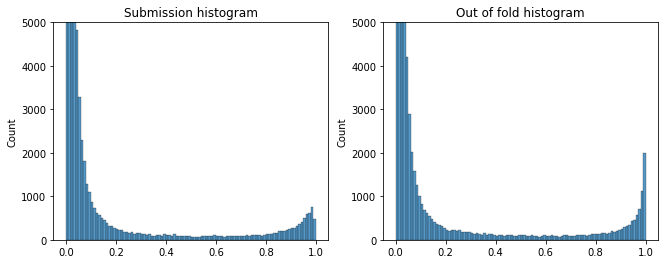

In [26]:
plt.subplot(1, 2, 1)
plt.subplots_adjust(left=-0.5)
p = sns.histplot(predictions, bins=100)
p.set_ylim(0,5000)
p.set_title("Submission histogram")

plt.subplot(1, 2, 2)
p = sns.histplot(out_of_fold, bins=100)
p.set_ylim(0,5000)
p.set_title("Out of fold histogram")

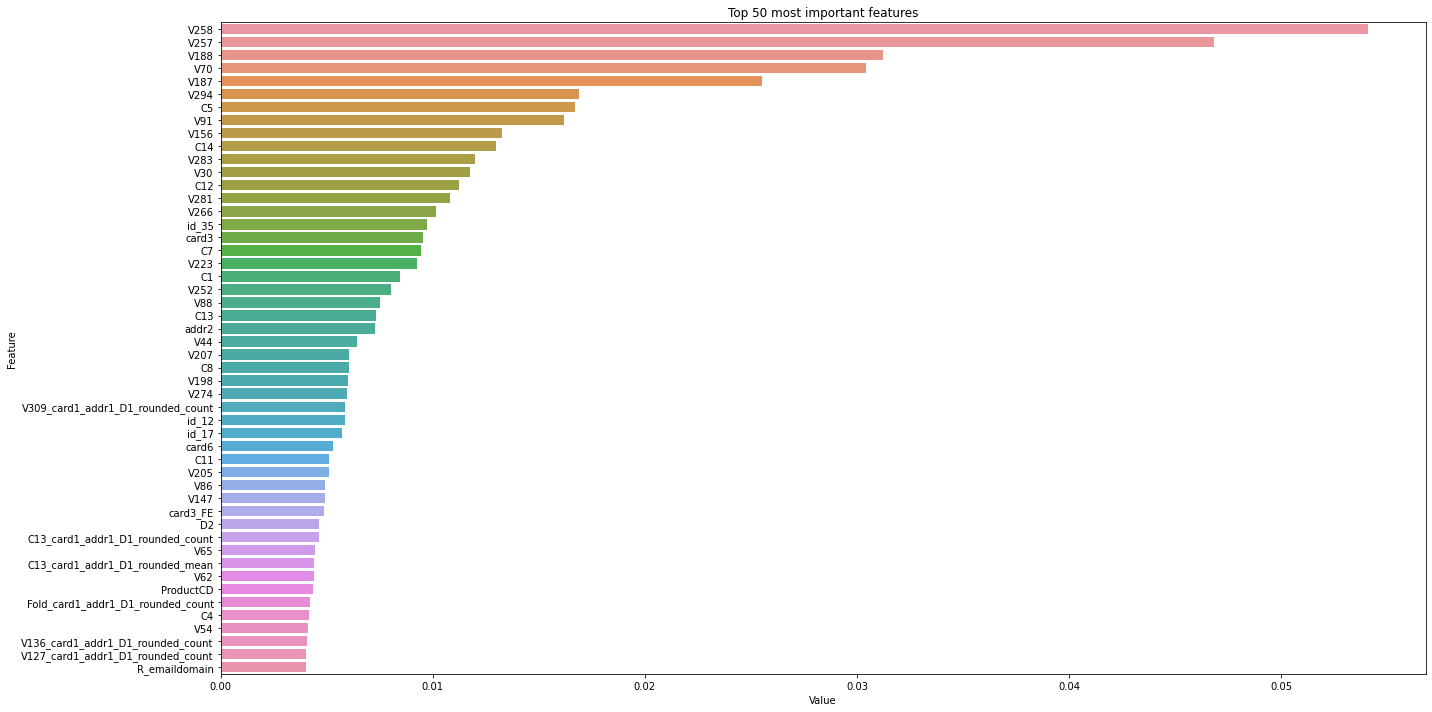

In [30]:
feature_importance = pd.DataFrame(sorted(zip(model.feature_importances_, columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('Top 50 most important features')
plt.tight_layout()
plt.show()

In [21]:
result = pd.read_csv("/content/drive/My Drive/result.csv")

In [22]:
result["isFraud"] = predictions

result.to_csv("/content/drive/My Drive/results_gpu.csv", index=False)